# Gaussian Mixture Model Classifier (GMM)


## Guassian Mixture

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

The formula for probability of mixture of gaussians is as follows:
* $z_i \in \{g_1, g_2, ..., g_m\}$
* $P(x) = \sum _{z} ^{} P(x|z) P(z) = \sum _{k=1} ^{m} P(x|z=g_k) P(z=g_k) = \sum _{z} ^{} \alpha _k N(x|\mu_k, \sigma_k)
$

As we can see from the above formula, P(x) is a ***linear combination*** of some gaussian distributions.

What we are going to do is to train an individual GMM model (with K Components) for each class. Therefore, we will have N GMM models (N is the number of classes).

To detect the label of a sample, we will use Maximum Likelihood (ML). We should find the likelihood of a sample in all classes and then select the class with the maximum likelihood as the label of the sample.


## Datasets


* ## [Iris dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)
    * coloumn names: ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
    * class names:      ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

* ## [UKM dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls)

* ## [Health dataset]()

* ## [Vehicle dataset]()

In [147]:
# imports

import csv
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [148]:
class Dataset:
    def __init__(self, dataset_name, dataset_path, coloumn_names, class_names, 
                 sep=None, output_column_name='class', 
                 shuffle=False, test_size=0.2, normalization_method='zero_mean_unit_var', 
                 individual_data_test_path = "None"):
        """
        self.x_train                 ->     vector-x0 + data_x_train_normalized
        self.x_test                  ->     vector-x0 + data_x_test_normalized
        
        self.y_train                 ->     y_train
        self.y_test                  ->     y_test
        """
        
        # read csv file using pandas
        self.normalization_method = normalization_method
        self.dataset_link = dataset_path
        self.sep = sep
        self.coloumn_names = coloumn_names
        self.class_names = class_names
        self.individual_data_test_path = individual_data_test_path
        RANDOM_STATE = 19
        
        if dataset_name == "iris":
            # read data using pandas
            self.data_frame = pd.read_csv(self.dataset_link, self.sep, names=self.coloumn_names)

            new_class_names = [i for i in range(len(class_names))]
            for i in range(len(class_names)):
                self.data_frame = self.data_frame.replace(class_names[i], new_class_names[i])

            # export y_train & y_test and convert to numpy array
            self.y = self.data_frame[output_column_name].to_numpy()
            # remove y from x_train & x_test
            self.x = self.data_frame.drop([output_column_name], axis=1).to_numpy()

            # normalize data
            self.x = self.normalize(normalization_method)

            # split test & train
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=test_size)

        elif dataset_name == "health":
            # read data using pandas
            self.data_frame = pd.read_csv(self.dataset_link, self.sep, names=self.coloumn_names)

            new_class_names = [i for i in range(len(class_names))]
            for i in range(len(class_names)):
                self.data_frame = self.data_frame.replace(class_names[i], new_class_names[i])

            # export y_train & y_test and convert to numpy array
            self.y = self.data_frame[output_column_name].to_numpy()
            # remove y from x_train & x_test
            self.x = self.data_frame.drop([output_column_name], axis=1).to_numpy()

            # normalize data
            self.x = self.normalize(normalization_method)
            
            # split test & train
            # rename label=2 to label=0 for working with in GMM
            self.y[self.y == 2] = 0
            x_train_c1, x_test_c1, y_train_c1, y_test_c1 = train_test_split(self.x[self.y == 0], self.y[self.y == 0], test_size=test_size, random_state=RANDOM_STATE)
            x_train_c2, x_test_c2, y_train_c2, y_test_c2 = train_test_split(self.x[self.y == 1], self.y[self.y == 1], test_size=test_size, random_state=RANDOM_STATE)

            self.x_test = np.vstack((x_test_c1, x_test_c2))
            self.y_test = np.concatenate((y_test_c1, y_test_c2))
            self.x_train = np.vstack((x_train_c1, x_train_c2))
            self.y_train = np.concatenate((y_train_c1, y_train_c2))
        
        elif dataset_name == "vehicle":
            with open(self.dataset_link) as file:
                lines = []
                class_label = []
                for line in file:
                    class_label.append(line.rstrip())
                    l = line.rstrip().split()[:-1]  ## delete label from end
                    lines.append(' '.join([str(elemnt) for elemnt in l]))

            ## Create class label ###
            label = []
            for i in range(0, len(class_label)):
                label.append((class_label[i].split()[-1]))

            for i in range(len(label)):
                if label[i] == 'van':
                    label[i] = 0
                if label[i] == 'saab':
                    label[i] = 1
                if label[i] == 'bus':
                    label[i] = 2
                if label[i] == 'opel':
                    label[i] = 3
            label = np.asarray(label)
            label_list = []
            for i in range(len(lines)):
                lst = []
                for j in range(len(lines[i].split(' '))):
                    strr = lines[i].split(' ')[j]
                    lst.append(int(strr))
                label_list.append(lst)
            file.close()
            
            xdata = np.asarray(label_list)
            self.x = xdata
            self.x = self.normalize(normalization_method)
            self.y = label
        
            # Split train and test data ###
            x_train_c1, x_test_c1, y_train_c1, y_test_c1 = train_test_split(xdata[label == 0], label[label == 0], train_size=0.8, random_state=RANDOM_STATE)
            x_train_c2, x_test_c2, y_train_c2, y_test_c2 = train_test_split(xdata[label == 1], label[label == 1], train_size=0.8, random_state=RANDOM_STATE)
            x_train_c3, x_test_c3, y_train_c3, y_test_c3 = train_test_split(xdata[label == 2], label[label == 2], train_size=0.8, random_state=RANDOM_STATE)
            x_train_c4, x_test_c4, y_train_c4, y_test_c4 = train_test_split(xdata[label == 3], label[label == 3], train_size=0.8, random_state=RANDOM_STATE)

            self.x_test = np.vstack((x_test_c1, x_test_c2, x_test_c3, x_test_c4))
            self.y_test = np.concatenate((y_test_c1, y_test_c2, y_test_c3, y_test_c4))
            self.x_train = np.vstack((x_train_c1, x_train_c2, x_train_c3, x_train_c4))
            self.y_train = np.concatenate((y_train_c1, y_train_c2, y_train_c3, y_train_c4))
            
        
        elif dataset_name == "UKM":
            # for UKM, we have data_train and data_test individually
            if (self.individual_data_test_path == "None"):
                csvfile = open(self.dataset_link)
                csvreader = csv.reader(csvfile, delimiter=',')
                next(csvreader)
                list_xy = [line.split(',') for line in csvfile]
                list_x1 = [float(data[0].rstrip()) for data in list_xy]
                list_x2 = [float(data[1].rstrip()) for data in list_xy]
                list_x3 = [float(data[2].rstrip()) for data in list_xy]
                list_x4 = [float(data[3].rstrip()) for data in list_xy]
                list_x5 = [float(data[4].rstrip()) for data in list_xy]
                ytrain_lsy = [(data[5].rstrip()) for data in list_xy]

                arry_x1 = np.asarray(list_x1).reshape(-1, 1)
                arry_x2 = np.asarray(list_x2).reshape(-1, 1)
                arry_x3 = np.asarray(list_x3).reshape(-1, 1)
                arry_x4 = np.asarray(list_x4).reshape(-1, 1)
                arry_x5 = np.asarray(list_x5).reshape(-1, 1)
                xtrain = np.concatenate((arry_x1, arry_x2, arry_x3, arry_x4, arry_x5), axis=1)
                ytrain = np.asarray(ytrain_lsy).reshape(-1, 1)

                # create class label
                label = []

                for i in range(len(ytrain)):
                    if ytrain[i] == 'very_low':
                        ytrain[i] = 0
                    if ytrain[i] == 'Low':
                        ytrain[i] = 1
                    if ytrain[i] == 'Middle':
                        ytrain[i] = 2
                    if ytrain[i] == 'High':
                        ytrain[i] = 3

                ylist = []
                for l in range(len(ytrain)):
                    ylist.append(int(ytrain[l]))
                ytrain = np.asarray(ylist)

                self.x = xtrain
                self.x = self.normalize(normalization_method)
                self.y = ytrain

                ## Split train and test data ###
                x_train_c1, x_test_c1, y_train_c1, y_test_c1 = train_test_split(xtrain[ytrain == 0], ytrain[ytrain == 0], train_size=0.8, random_state=RANDOM_STATE)
                x_train_c2, x_test_c2, y_train_c2, y_test_c2 = train_test_split(xtrain[ytrain == 1], ytrain[ytrain == 1], train_size=0.8, random_state=RANDOM_STATE)
                x_train_c3, x_test_c3, y_train_c3, y_test_c3 = train_test_split(xtrain[ytrain == 2], ytrain[ytrain == 2], train_size=0.8, random_state=RANDOM_STATE)
                x_train_c4, x_test_c4, y_train_c4, y_test_c4 = train_test_split(xtrain[ytrain == 3], ytrain[ytrain == 3], train_size=0.8, random_state=RANDOM_STATE)

                self.x_test = np.vstack((x_test_c1, x_test_c2, x_test_c3, x_test_c4))
                self.y_test = np.concatenate((y_test_c1, y_test_c2, y_test_c3, y_test_c4))
                self.x_train = np.vstack((x_train_c1, x_train_c2, x_train_c3, x_train_c4))
                self.y_train = np.concatenate((y_train_c1, y_train_c2, y_train_c3, y_train_c4))

            # here we have the two files for data-test and train individually
            else:
                # read data_train
                csvfile = open(self.dataset_link)
                csvreader = csv.reader(csvfile, delimiter=',')
                next(csvreader)
                list_xy = [line.split(',') for line in csvfile]
                list_x1 = [float(data[0].rstrip()) for data in list_xy]
                list_x2 = [float(data[1].rstrip()) for data in list_xy]
                list_x3 = [float(data[2].rstrip()) for data in list_xy]
                list_x4 = [float(data[3].rstrip()) for data in list_xy]
                list_x5 = [float(data[4].rstrip()) for data in list_xy]
                ytrain_lsy = [(data[5].rstrip()) for data in list_xy]

                arry_x1 = np.asarray(list_x1).reshape(-1, 1)
                arry_x2 = np.asarray(list_x2).reshape(-1, 1)
                arry_x3 = np.asarray(list_x3).reshape(-1, 1)
                arry_x4 = np.asarray(list_x4).reshape(-1, 1)
                arry_x5 = np.asarray(list_x5).reshape(-1, 1)
                xtrain = np.concatenate((arry_x1, arry_x2, arry_x3, arry_x4, arry_x5), axis=1)
                ytrain = np.asarray(ytrain_lsy).reshape(-1, 1)
                # create class label
                label = []
                for i in range(len(ytrain)):
                    if ytrain[i] == 'very_low':
                        ytrain[i] = 0
                    if ytrain[i] == 'Low':
                        ytrain[i] = 1
                    if ytrain[i] == 'Middle':
                        ytrain[i] = 2
                    if ytrain[i] == 'High':
                        ytrain[i] = 3
                ylist = []
                for l in range(len(ytrain)):
                    ylist.append(int(ytrain[l]))
                ytrain = np.asarray(ylist)
                self.x = xtrain
                self.x_train = self.normalize(normalization_method)
                self.y_train = ytrain
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                # read data_test
                csvfile = open(self.individual_data_test_path)
                csvreader = csv.reader(csvfile, delimiter=',')
                next(csvreader)
                list_xy = [line.split(',') for line in csvfile]
                list_x1 = [float(data[0].rstrip()) for data in list_xy]
                list_x2 = [float(data[1].rstrip()) for data in list_xy]
                list_x3 = [float(data[2].rstrip()) for data in list_xy]
                list_x4 = [float(data[3].rstrip()) for data in list_xy]
                list_x5 = [float(data[4].rstrip()) for data in list_xy]
                ytest_lsy = [(data[5].rstrip()) for data in list_xy]

                arry_x1 = np.asarray(list_x1).reshape(-1, 1)
                arry_x2 = np.asarray(list_x2).reshape(-1, 1)
                arry_x3 = np.asarray(list_x3).reshape(-1, 1)
                arry_x4 = np.asarray(list_x4).reshape(-1, 1)
                arry_x5 = np.asarray(list_x5).reshape(-1, 1)
                xtest = np.concatenate((arry_x1, arry_x2, arry_x3, arry_x4, arry_x5), axis=1)
                ytest = np.asarray(ytest_lsy).reshape(-1, 1)
                # create class label
                label = []
                for i in range(len(ytest)):
                    if ytest[i] == 'Very Low':
                        ytest[i] = 0
                    if ytest[i] == 'Low':
                        ytest[i] = 1
                    if ytest[i] == 'Middle':
                        ytest[i] = 2
                    if ytest[i] == 'High':
                        ytest[i] = 3
                ylist = []
                for l in range(len(ytest)):
                    ylist.append(int(ytest[l]))
                ytest = np.asarray(ylist)
                self.x = xtest
                self.x_test = self.normalize(normalization_method)
                self.y_test = ytest
                # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                # append y_train & y_test to create y
                # append x_test & x_train to create x
                self.x = np.concatenate((self.x_train, self.x_test), axis=0)
                self.y = np.concatenate((self.y_train, self.y_test), axis=0)
                
        
    """
    Normalizing data improves the convergence of learning model and causes that smaller features also be able to affect the model parameters.
    """
    def normalize(self, normalization_method):
        if normalization_method == 'none':
            print("No normalization.")
            t = self.x

        if normalization_method == 'zero_mean_unit_var':
            print("zero-mean & unit_variance normalization.")
            t = self.zero_mean_unit_variance(self.x)            
            
        if normalization_method == 'scale_0_1':
            print("scaling to [0, 1] normalization.")
            t = self.scaling_between_0_1(self.x)
        return t
     
    
    def scaling_between_0_1(self, numpy_array):
        '''
        Scaling
        '''
        normed_numpy_array = (numpy_array - numpy_array.min()) / (numpy_array.max() - numpy_array.min())
        return normed_numpy_array
    

    def zero_mean_unit_variance(self, numpy_array):
        '''
        Standardization
        '''
        normed_numpy_array = (numpy_array - numpy_array.mean()) / numpy_array.std()
        return normed_numpy_array

In [152]:
iris_dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_dataset_link = './datasets/iris.data'
Iris = Dataset(dataset_name="iris", dataset_path=iris_dataset_link,
                  coloumn_names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], 
                  class_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], 
                  output_column_name='class', normalization_method='scale_0_1')
print("Iris x_train: ", Iris.x_train.shape)
print("Iris x_test: ", Iris.x_test.shape)

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

health_dataset_path = "./datasets/Health.dat"
coloumn_names = [str(i) for i in range(13)] + ['class']
health = Dataset(dataset_name="health", dataset_path=health_dataset_path, 
                  coloumn_names=coloumn_names, 
                  sep=' ',
                  class_names=['1', '2'], 
                  output_column_name='class', normalization_method='zero_mean_unit_var')
print("health x_train: ", health.x_train.shape)
print("health x_test: ", health.x_test.shape)

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

# ukm_dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls'
ukm_dataset_link = './datasets/UKM_train.csv'

UKM = Dataset(dataset_name="UKM", dataset_path=ukm_dataset_link, 
              coloumn_names=['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], 
              class_names=['very_low', 'Low', 'Middle', 'High'], 
              output_column_name='UNS', normalization_method='zero_mean_unit_var', 
              individual_data_test_path='./datasets/UKM_test.csv')
print("UKM x_train: ", UKM.x_train.shape)
print("UKM x_test: ", UKM.x_test.shape)

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

coloumn_names = ['COMPACTNESS', 'CIRCULARITY', 'DISTANCE CIRCULARITY', 'RADIUS RATIO', 
                 'PR.AXIS ASPECT RATIO', 'MAX.LENGTH ASPECT RATIO', 
                 'SCATTER RATIO 1', 'SCATTER RATIO 2', 
                 'PR.AXIS RECTANGULARITY', 'MAX.LENGTH RECTANGULARITY', 
                 'SCALED VARIANCE ALONG MAJOR AXIS', 'SCALED VARIANCE ALONG MINOR AXIS', 
                 'SCALED RADIUS OF GYRATION', 
                 'SKEWNESS ABOUT MAJOR AXIS', 'SKEWNESS ABOUT MINOR AXIS', 
                 'KURTOSIS ABOUT MINOR AXIS', 'KURTOSIS ABOUT MAJOR AXIS', 
                 'HOLLOWS RATIO', 'class']

coloumn_names = [str(i) for i in range(18)] + ['class']
vehicle = Dataset(dataset_name="vehicle", dataset_path='./datasets/Vehicle.dat', 
                  coloumn_names=coloumn_names, 
                  sep=" ",
                  class_names=['van', 'sub', 'bus', 'opel'], 
                  output_column_name='class', normalization_method='zero_mean_unit_var')
print("vehivle x_train: ", vehicle.x_train.shape)
print("vehivle x_test: ", vehicle.x_test.shape)

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

scaling to [0, 1] normalization.
Iris x_train:  (120, 4)
Iris x_test:  (30, 4)
zero-mean & unit_variance normalization.
health x_train:  (216, 13)
health x_test:  (54, 13)
zero-mean & unit_variance normalization.
zero-mean & unit_variance normalization.
UKM x_train:  (258, 5)
UKM x_test:  (145, 5)
zero-mean & unit_variance normalization.
vehivle x_train:  (74, 18)
vehivle x_test:  (20, 18)


In [153]:
class GMM():
    def __init__(self, x_train, x_test, y_train, y_test, k, dataset_name):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
        self.k = k
        self.dataset_name = dataset_name

    def accuracy(self, y, y_pred):
        res = 0
        for i in range(0, len(y)):
            if y_pred[i] == y[i]:
                res += 1
        return (res / float(len(y))) * 100

    def gmm(self):
        self.labels = np.unique(self.y_train)
        
        train_predict = []
        test_predict = []
        for label in self.labels:
            gmm = GaussianMixture(n_components=self.k)
            gmm.fit(self.x_train[self.y_train == label])
            
            # gmm.score_sample() on x_train
            train_pred_val = gmm.score_samples(self.x_train)
            train_predict.append(train_pred_val)
            
            # gmm.score_sample() on x_test
            test_pred_val = gmm.score_samples(self.x_test)
            test_predict.append(test_pred_val)
        
        # finds labels of x_train
        train_max_per_class = np.stack(train_predict, axis=-1)
        self.predected_y_train = np.argmax(train_max_per_class, axis=-1)
        
        # finds labels of x_train
        test_max_per_class = np.stack(test_predict, axis=-1)
        self.predected_y_test = np.argmax(test_max_per_class, axis=-1)
        
        # find accuracies
        self.train_accuracy = self.accuracy(self.y_train, self.predected_y_train)
        self.test_accuracy = self.accuracy(self.y_test, self.predected_y_test)
        
    def plot_data_(self, x, y, title="plot"):
        y_list = []
        for i in range(len(y)):
            y_list.append(y[i])
        df = pd.DataFrame(dict(x=x[:, 0], y=x[:, 1], label=y_list))
        colors = {0: 'orange', 1: 'green', 2: 'blue', 3: 'brown'}
        fig1, ax = plt.subplots()
        groups = df.groupby('label')
        for key, group in groups:
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key], title=title)
        plt.xlabel('X0')
        plt.ylabel('X1')
        plt.show()
        return
    
    def plot_data_2d_PCA(self, x, y, title="plot"):
        num_of_colors = len(np.unique(y))
        y_list = []
        for i in range(len(y)):
            y_list.append(y[i])
        df = pd.DataFrame(x)
        df_2 = df.copy()
        df['label'] = y_list
        
        # for reproducability of the results
        np.random.seed(42)
        rndperm = np.random.permutation(df.shape[0])
        
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(df_2.values)
        df['pca-one'] = pca_result[:,0]
        df['pca-two'] = pca_result[:,1]        
        plt.figure(figsize=(6,4))
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue="label",
            palette=sns.color_palette("tab10", num_of_colors),
            data=df.loc[rndperm,:],
            legend="full",
            alpha=0.3
        )
        plt.title(title)
        plt.show()
        return
    
    def plot_data_3d_PCA(self, x, y, title="plot"):
        num_of_colors = len(np.unique(y))
        y_list = []
        for i in range(len(y)):
            y_list.append(y[i])
        df = pd.DataFrame(x)
        df_2 = df.copy()
        df['label'] = y_list
        
        # for reproducability of the results
        np.random.seed(42)
        rndperm = np.random.permutation(df.shape[0])
        
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(df_2.values)
        df['pca-one'] = pca_result[:,0]
        df['pca-two'] = pca_result[:,1] 
        df['pca-three'] = pca_result[:,2]
        
        ax = plt.figure(figsize=(10,6)).gca(projection='3d')
        ax.scatter(
            xs=df.loc[rndperm,:]["pca-one"], 
            ys=df.loc[rndperm,:]["pca-two"], 
            zs=df.loc[rndperm,:]["pca-three"], 
            c=df.loc[rndperm,:]["label"], 
            cmap='tab10'
        )
        ax.set_xlabel('pca-one')
        ax.set_ylabel('pca-two')
        ax.set_zlabel('pca-three')
        plt.title(title)
        
        return
 
    def plot(self, plot_type="3d_pca"):
        if plot_type == "3d_pca":
            self.plot_data_3d_PCA(self.x_train, self.predected_y_train, f'{self.dataset_name} | Train Data | k={self.k} | Accuracy={self.train_accuracy}')
            self.plot_data_3d_PCA(self.x_test, self.predected_y_test, f'{self.dataset_name} | Test Data | k={self.k} | Accuracy={self.test_accuracy}')
        if plot_type == "2d_pca":
            self.plot_data_2d_PCA(self.x_train, self.predected_y_train, f'{self.dataset_name} | Train Data | k={self.k} | Accuracy={self.train_accuracy}')
            self.plot_data_2d_PCA(self.x_test, self.predected_y_test, f'{self.dataset_name} | Test Data | k={self.k} | Accuracy={self.test_accuracy}')
        if plot_type == "2d_first_second_features":
            self.plot_data_(self.x_train, self.predected_y_train, f'{self.dataset_name} | Train Data | k={self.k} | Accuracy={self.train_accuracy}')
            self.plot_data_(self.x_test, self.predected_y_test, f'{self.dataset_name} | Test Data | k={self.k} | Accuracy={self.test_accuracy}')


In [154]:
from statistics import mean

def find_best_k_GMM(dataset, dataset_name, Ks_array, split=5, repeat=5):
    kfold = RepeatedKFold(n_splits=split, n_repeats=repeat, random_state=2624)

    train_best_acc = 0
    test_best_acc = 0
    best_k = None
    
    train_acc = []
    test_acc = []
    
    for k in Ks_array:
        # create folds
        for train_index, test_index in kfold.split(dataset.x):
            x_train, x_test = dataset.x[train_index], dataset.x[test_index]
            y_train, y_test = dataset.y[train_index], dataset.y[test_index]
            
            gmm = GMM(x_train, x_test, y_train, y_test, k, dataset_name)
            gmm.gmm()
            train_acc.append(gmm.train_accuracy)
            test_acc.append(gmm.test_accuracy)
            
        mean_train_acc = mean(train_acc)
        mean_test_acc = mean(test_acc)
        print('5 time 5 fold: train accuracy for k = ', k, ' is ', mean_train_acc, ' in ', dataset_name)
        print('5 time 5 fold: test  accuracy for k = ', k, ' is ', mean_test_acc, ' in ', dataset_name)
        if mean_train_acc > train_best_acc and mean_test_acc > test_best_acc:
            best_k = k
            train_best_acc = mean_train_acc
            test_best_acc = mean_test_acc
        
    return best_k, train_best_acc, test_best_acc

## Iris Dataset (k=1)

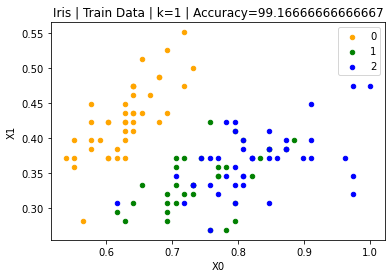

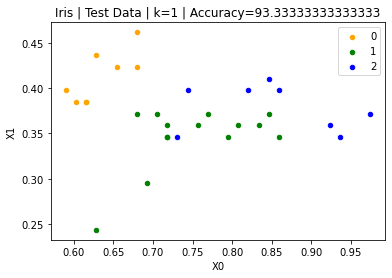

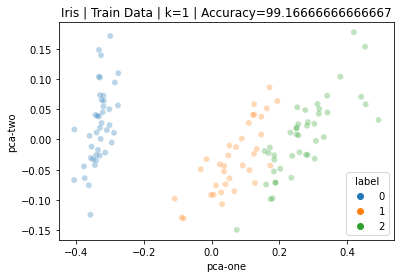

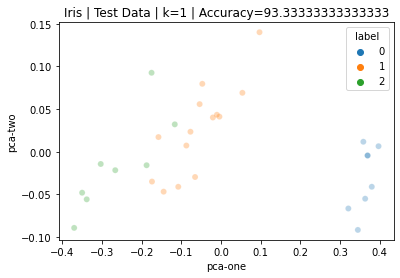

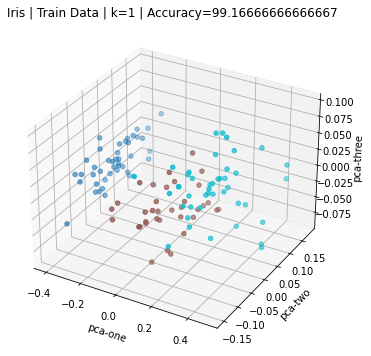

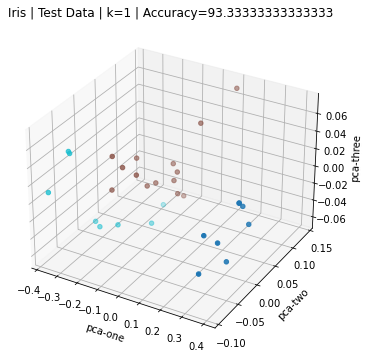

In [155]:
gmm = GMM(Iris.x_train, Iris.x_test, Iris.y_train, Iris.y_test, k=1, dataset_name='Iris')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Iris Dataset (k=5)

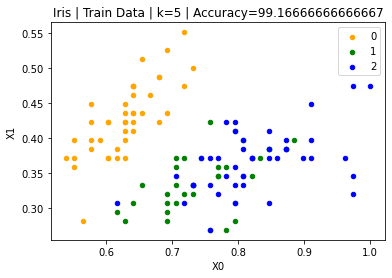

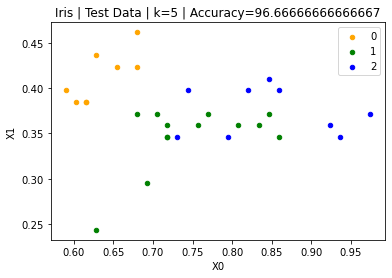

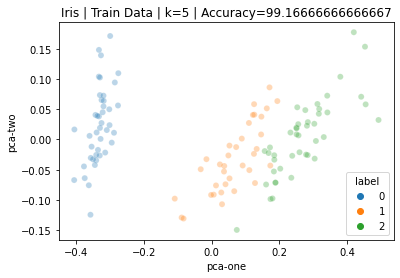

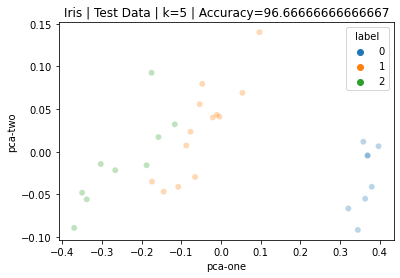

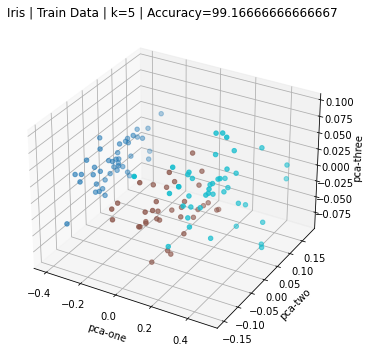

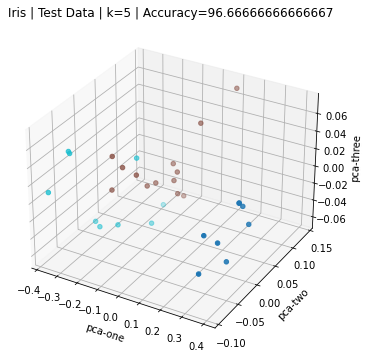

In [156]:
gmm = GMM(Iris.x_train, Iris.x_test, Iris.y_train, Iris.y_test, k=5, dataset_name='Iris')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Iris Dataset (k=10)

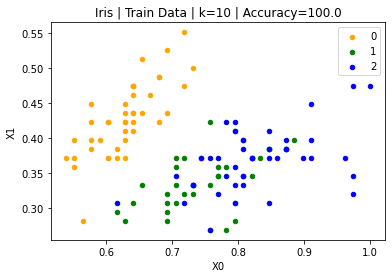

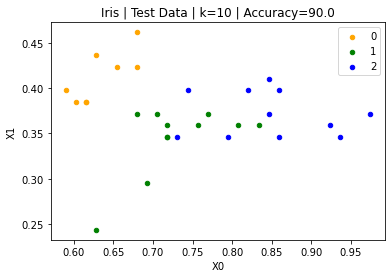

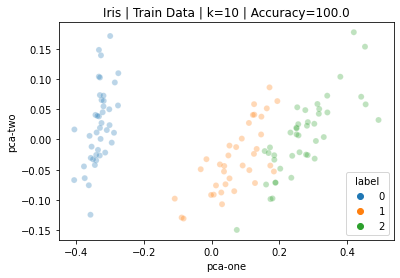

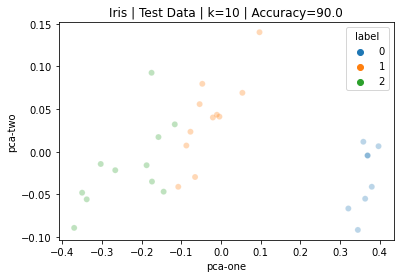

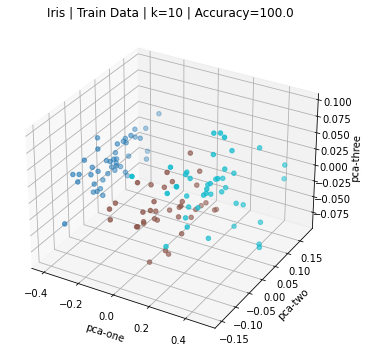

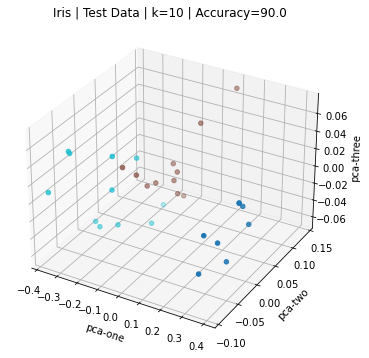

In [157]:
gmm = GMM(Iris.x_train, Iris.x_test, Iris.y_train, Iris.y_test, k=10, dataset_name='Iris')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Iris Dataset (best k using 5-fold)

In [158]:
Ks_array = [1, 5, 10]
best_k, train_best_acc, test_best_acc = find_best_k_GMM(Iris, 'Iris', Ks_array)
print("best k: ", best_k)
print("train best accuracy: ", train_best_acc)
print("test best accuracy: ", test_best_acc)

5 time 5 fold: train accuracy for k =  1  is  98.16666666666667  in  Iris
5 time 5 fold: test  accuracy for k =  1  is  97.86666666666666  in  Iris
5 time 5 fold: train accuracy for k =  5  is  98.86666666666667  in  Iris
5 time 5 fold: test  accuracy for k =  5  is  96.6  in  Iris
5 time 5 fold: train accuracy for k =  10  is  99.24444444444444  in  Iris
5 time 5 fold: test  accuracy for k =  10  is  94.57777777777778  in  Iris
best k:  1
train best accuracy:  98.16666666666667
test best accuracy:  97.86666666666666


## Health Dataset (k=1)

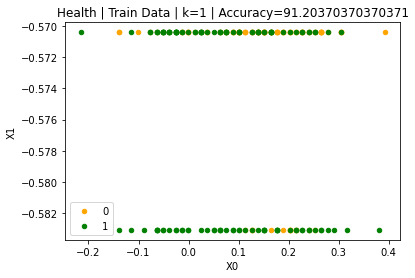

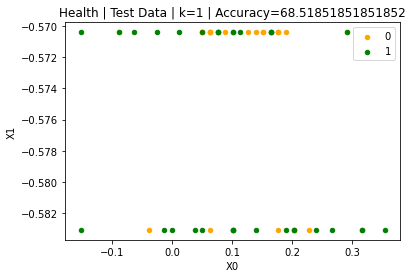

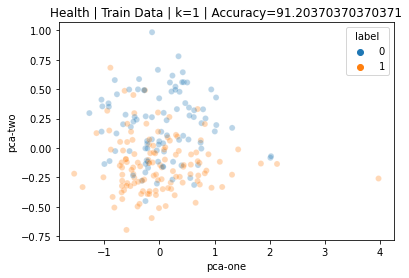

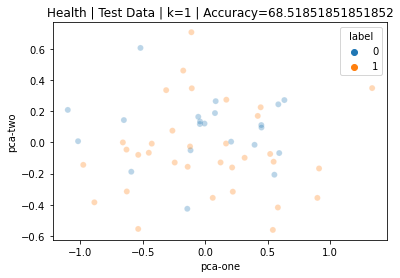

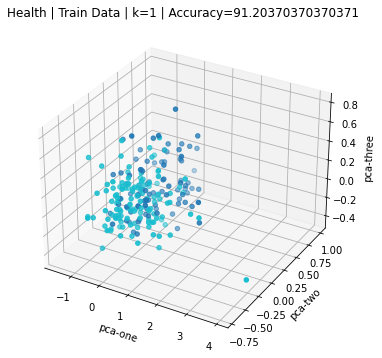

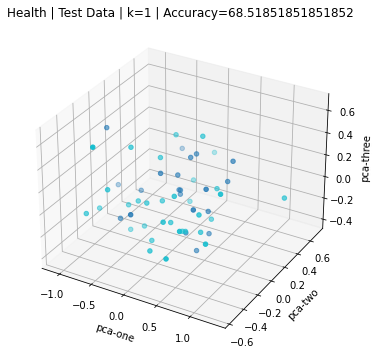

In [159]:
gmm = GMM(health.x_train, health.x_test, health.y_train, health.y_test, k=1, dataset_name='Health')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Health Dataset (k=5)

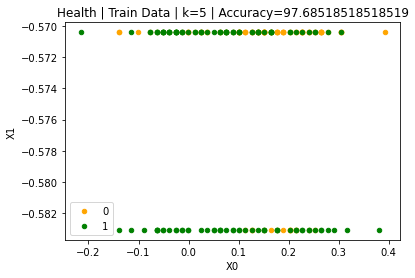

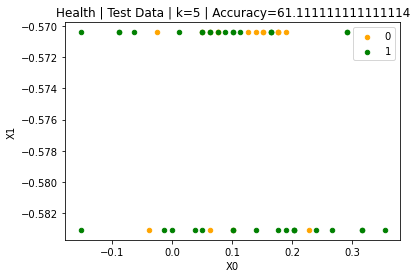

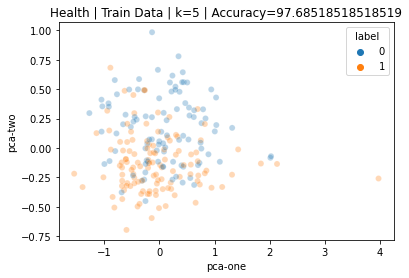

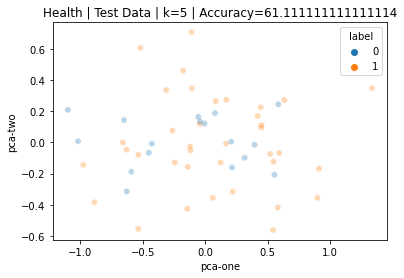

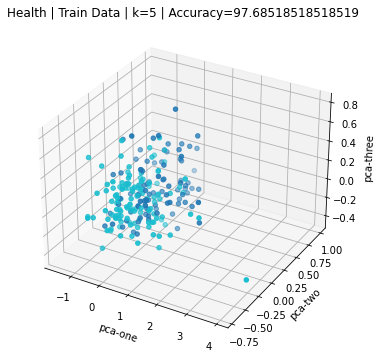

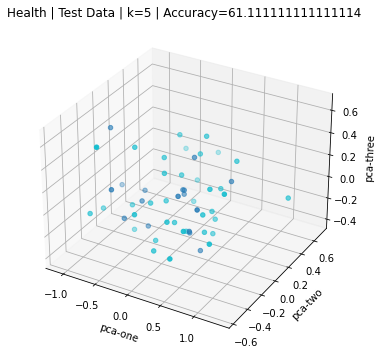

In [160]:
gmm = GMM(health.x_train, health.x_test, health.y_train, health.y_test, k=5, dataset_name='Health')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Health Dataset (k=10)

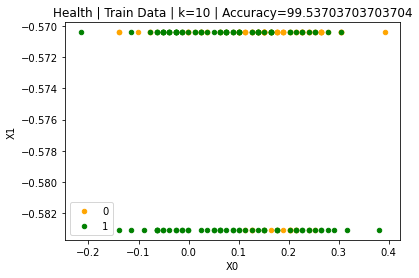

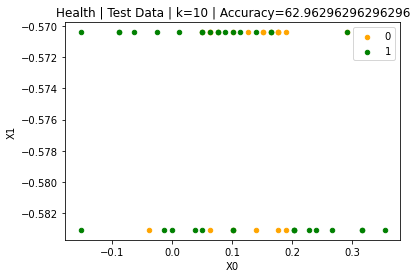

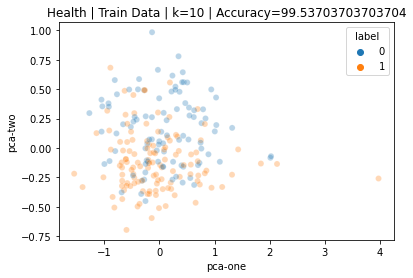

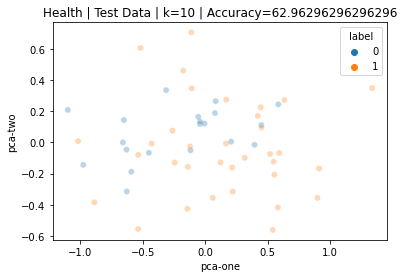

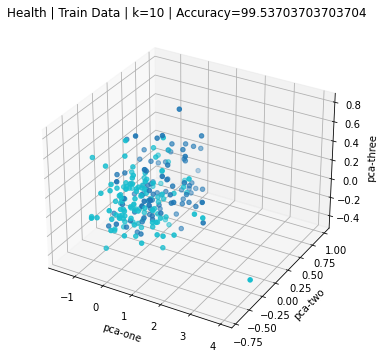

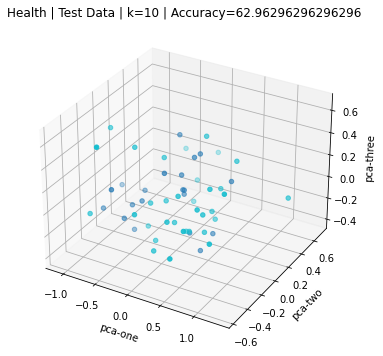

In [161]:
gmm = GMM(health.x_train, health.x_test, health.y_train, health.y_test, k=10, dataset_name='Health')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Health Dataset (best k using 5-fold)

In [162]:
Ks_array = [1, 5, 10]
best_k, train_best_acc, test_best_acc = find_best_k_GMM(health, 'Health', Ks_array)
print("best k: ", best_k)
print("train best accuracy: ", train_best_acc)
print("test best accuracy: ", test_best_acc)

5 time 5 fold: train accuracy for k =  1  is  87.98148148148148  in  Health
5 time 5 fold: test  accuracy for k =  1  is  82.37037037037037  in  Health
5 time 5 fold: train accuracy for k =  5  is  92.79629629629629  in  Health
5 time 5 fold: test  accuracy for k =  5  is  78.22222222222223  in  Health
5 time 5 fold: train accuracy for k =  10  is  95.16666666666667  in  Health
5 time 5 fold: test  accuracy for k =  10  is  75.06172839506172  in  Health
best k:  1
train best accuracy:  87.98148148148148
test best accuracy:  82.37037037037037


## UKM Dataset (k=1)

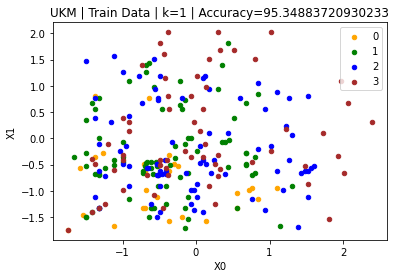

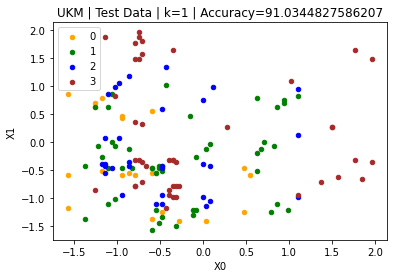

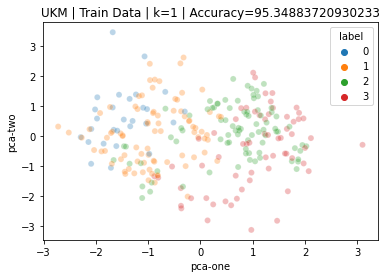

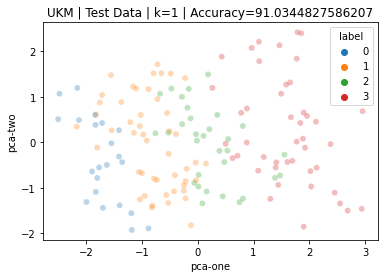

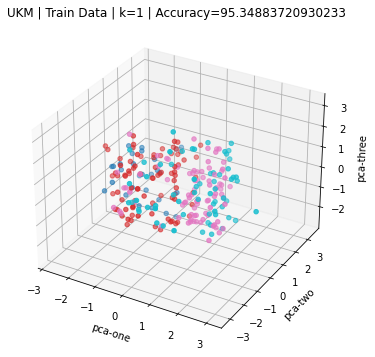

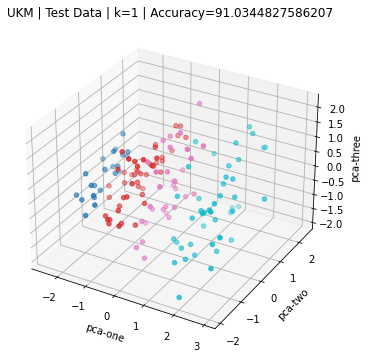

In [163]:
gmm = GMM(UKM.x_train, UKM.x_test, UKM.y_train, UKM.y_test, k=1, dataset_name='UKM')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## UKM Dataset (k=5)

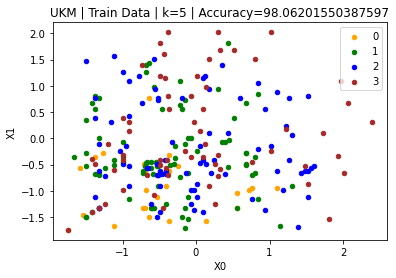

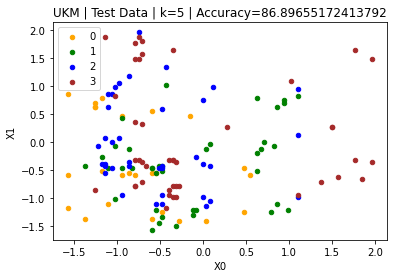

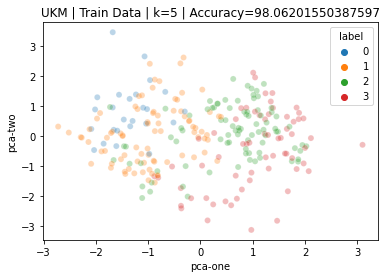

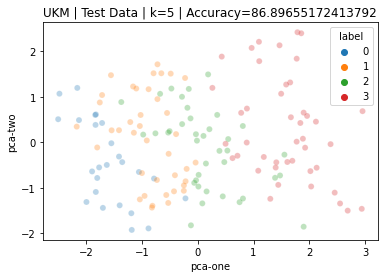

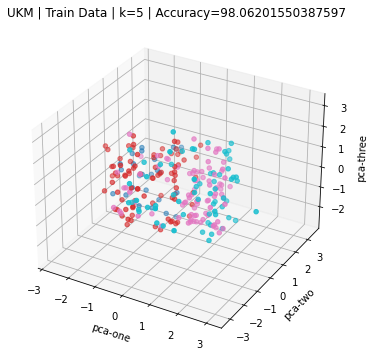

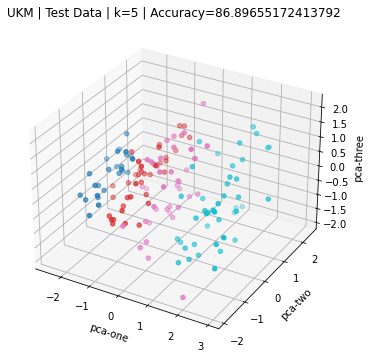

In [164]:
gmm = GMM(UKM.x_train, UKM.x_test, UKM.y_train, UKM.y_test, k=5, dataset_name='UKM')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## UKM Dataset (k=10)

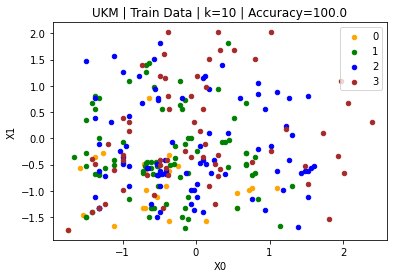

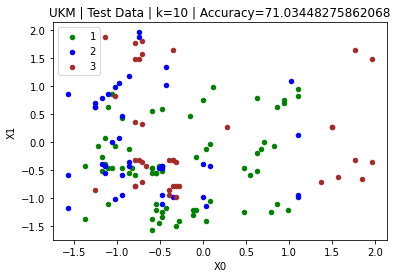

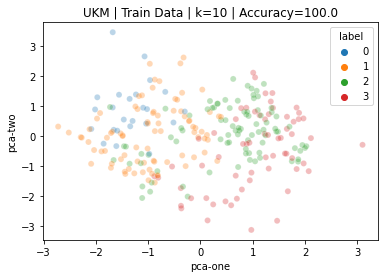

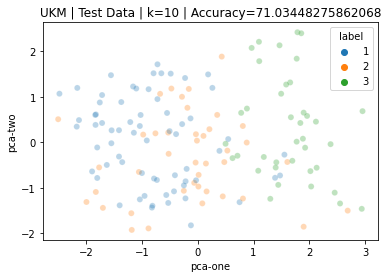

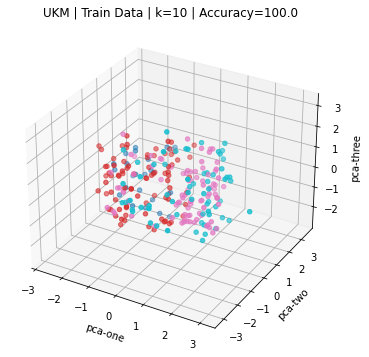

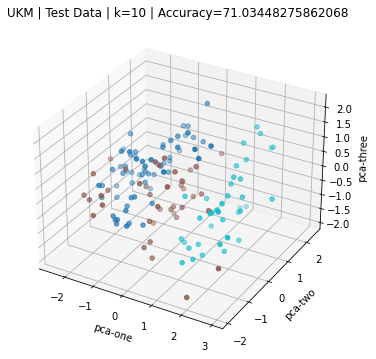

In [165]:
gmm = GMM(UKM.x_train, UKM.x_test, UKM.y_train, UKM.y_test, k=10, dataset_name='UKM')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## UKM Dataset (best k using 5-fold)

In [166]:
Ks_array = [1, 5, 10]
best_k, train_best_acc, test_best_acc = find_best_k_GMM(UKM, 'UKM', Ks_array)
print("best k: ", best_k)
print("train best accuracy: ", train_best_acc)
print("test best accuracy: ", test_best_acc)

5 time 5 fold: train accuracy for k =  1  is  96.33994192642733  in  UKM
5 time 5 fold: test  accuracy for k =  1  is  94.74012345679013  in  UKM
5 time 5 fold: train accuracy for k =  5  is  97.27665711593562  in  UKM
5 time 5 fold: test  accuracy for k =  5  is  92.4320987654321  in  UKM
5 time 5 fold: train accuracy for k =  10  is  97.97760385618778  in  UKM
5 time 5 fold: test  accuracy for k =  10  is  88.88086419753087  in  UKM
best k:  1
train best accuracy:  96.33994192642733
test best accuracy:  94.74012345679013


## Vehicle Dataset (k=1)

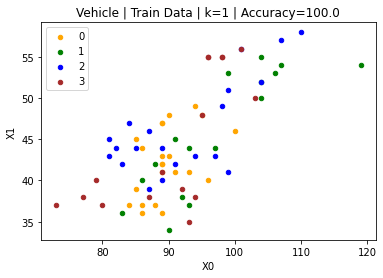

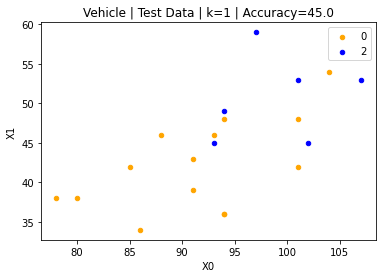

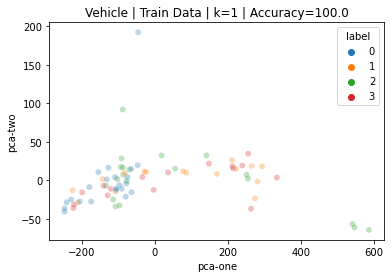

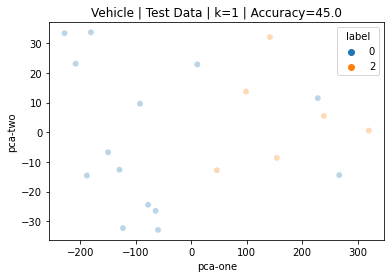

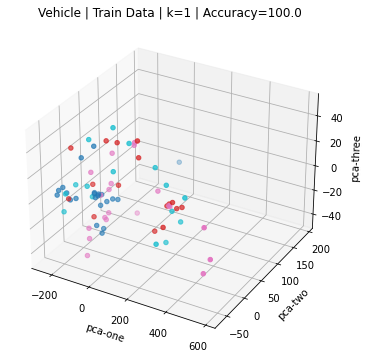

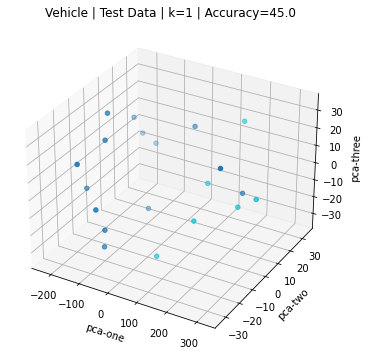

In [167]:
gmm = GMM(vehicle.x_train, vehicle.x_test, vehicle.y_train, vehicle.y_test, k=1, dataset_name='Vehicle')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Vehicle Dataset (k=5)

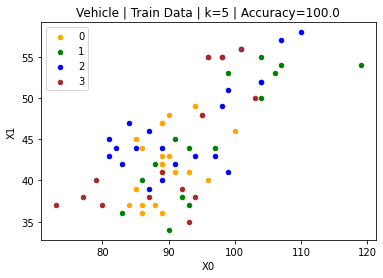

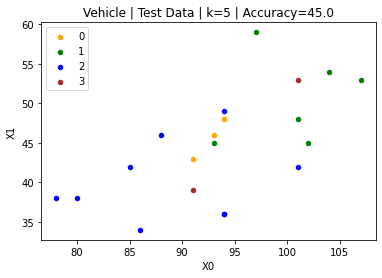

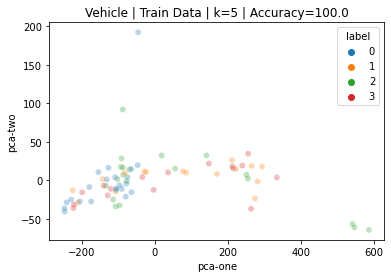

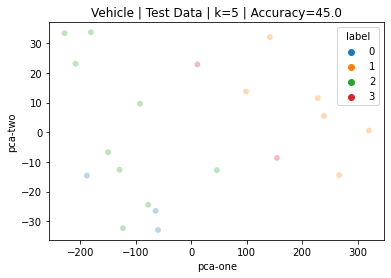

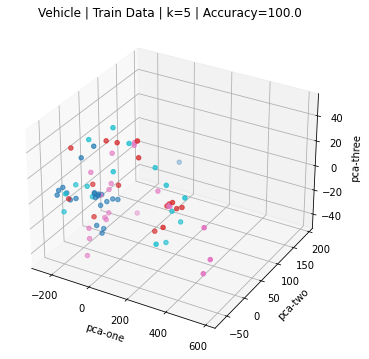

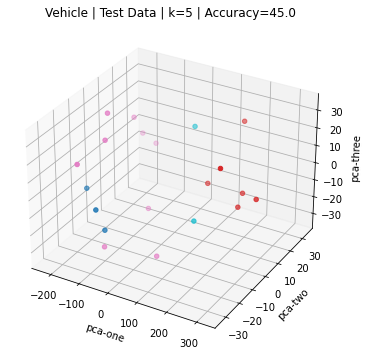

In [168]:
gmm = GMM(vehicle.x_train, vehicle.x_test, vehicle.y_train, vehicle.y_test, k=5, dataset_name='Vehicle')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")


## Vehicle Dataset (k=10)

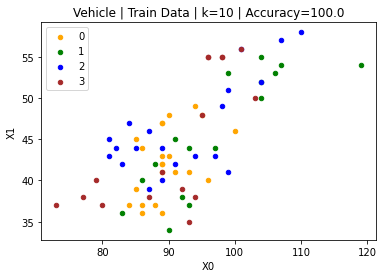

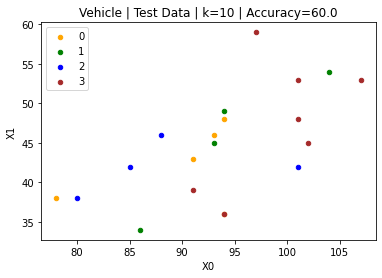

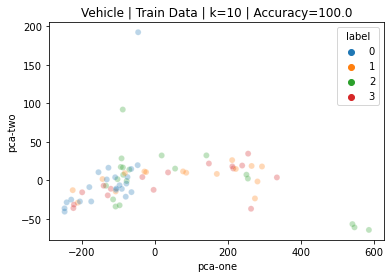

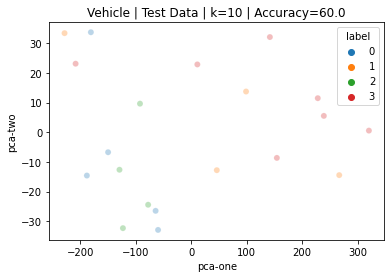

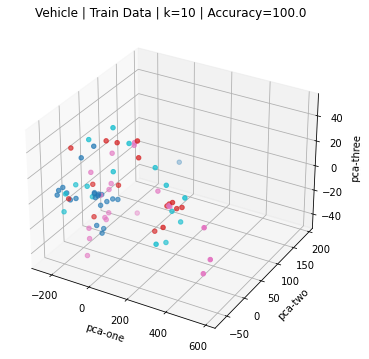

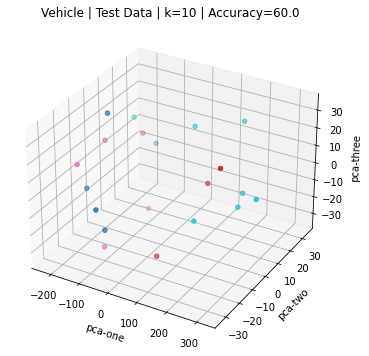

In [169]:
gmm = GMM(vehicle.x_train, vehicle.x_test, vehicle.y_train, vehicle.y_test, k=10, dataset_name='Vehicle')
gmm.gmm()
gmm.plot("2d_first_second_features")
gmm.plot("2d_pca")
gmm.plot("3d_pca")

## Vehicle Dataset (best k using 5-fold)

In [170]:
Ks_array = [1, 5, 10]
best_k, train_best_acc, test_best_acc = find_best_k_GMM(vehicle, 'Vehicle', Ks_array)
print("best k: ", best_k)
print("train best accuracy: ", train_best_acc)
print("test best accuracy: ", test_best_acc)

5 time 5 fold: train accuracy for k =  1  is  100.0  in  Vehicle
5 time 5 fold: test  accuracy for k =  1  is  64.97076023391813  in  Vehicle
5 time 5 fold: train accuracy for k =  5  is  100.0  in  Vehicle
5 time 5 fold: test  accuracy for k =  5  is  56.432748538011694  in  Vehicle
5 time 5 fold: train accuracy for k =  10  is  100.0  in  Vehicle
5 time 5 fold: test  accuracy for k =  10  is  55.773879142300196  in  Vehicle
best k:  1
train best accuracy:  100.0
test best accuracy:  64.97076023391813
